# Assignment 6: Continuous-time discrete models

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

# General instructions

1. Do not remove any text or code cells; do not leave redundent print messages.
1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 4 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. Your code should run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, numba, multiprocessig.
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment6"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

**Note: in this assignment you need to do ex 1 and either ex 2 or ex 3. If you do both ex 2 and ex 3 we will grade according to the better answer**.

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.stats
from scipy.integrate import solve_ivp
import seaborn as sns
sns.set_context('notebook')
red, blue, green, purple, orange, yellow = sns.color_palette('Set1', 6)
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed

# Background

Recall our work on the predator-prey model:

In [2]:
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])

In [3]:
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 50000
XY = np.empty((2, steps))
XY[:,0] = 50, 100
dt = 0.001

for t_ in range(1, steps):
    XY[:,t_] = XY[:, t_-1] + dxydt(t_, XY[:, t_-1], b, h, ϵ, d) * dt
X, Y = XY
T = np.arange(0, steps*dt, dt)

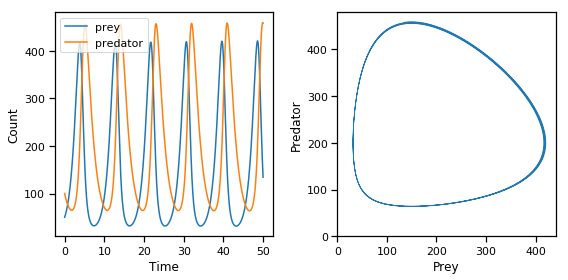

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(T, X, label='prey')
ax.plot(T, Y, label='predator')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.legend();

ax = axes[1]
ax.plot(X, Y, lw=0.5)
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')
ax.set(xlim=(0, None), ylim=(0, None))

fig.tight_layout()

We talked about how these cycles only *seem* stable, but really, they are prone to extinctions due to stochastic events, leading to either exitinction of both species or extinction of the predator and explosion of the prey population.

In this assignment you will implement a stochastic simulation of the dynamics using Gillespie's algorithm, which we covered in lecture 10.

The following is a table of reactions and their rates for the predator-prey dynamics.

$x$ denote the prey, $y$ denotes the predator; use the same rates as used in the deterministic model: $b$, $h$, $\epsilon$, and $d$.

Note that $h$ describes the rate at which predators hunts prey, whereas $\epsilon$ described the rate at which predators convert prey mass into predator mass.
We didn't have a scenario like that in the molecular dynamics case and it requires a bit of sophistication.

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } a_i \\
x \rightarrow x+1,\;\;\;\; & bx \\
x \rightarrow x-1, \;\;\;\; & (1-\epsilon) hxy \\
x, y \rightarrow x-1, y+1, \;\;\;\; &  \epsilon h x y \\
y \rightarrow y-1, \;\;\;\; & dy.
\end{array}
\end{align}

# Ex 1 

**Write a Gillespie simulation for the predator-prey dynamics.**

**Run a single simulation and plot it together with the deterministic dynamics.**

Note that once the predators are extinct there is no more use to continue running the simulation as the prey will just grow exponentiallt according to $dx/dt = bx$.

Remember

In [5]:
@numba.jit 
def get_rates(x, y, b, h, ϵ, d): ###
    return np.array([
        b*x,             # prey production rate
        (1-ϵ)*h*x*y,     # prey degradation
        ϵ*h*x*y,         # prey degradation and predator production
        d*y              # prey degradation
    ]) 

In [6]:
@numba.jit
def draw_time(rates): ###
    assert rates.sum() > 0, rates
    total_rate = rates.sum()
    return np.random.exponential(1/total_rate)
    

In [7]:
def draw_reaction(rates): ###
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()
    

In [8]:
updates = np.array([
    [1, 0],  
    [-1, 0], 
    [-1, 1], 
    [0, -1]  
])

In [9]:
def gillespie_step(x, y, b, h, ϵ, d): ###
    rates = get_rates(x, y, b, h, ϵ, d)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δx, Δy = updates[ri]
    return Δt, Δx, Δy


One step of the simulation goes through a single update.

In [11]:
t, x, y = 0, X[0], Y[0]
print(t,x,y)

0 50.0 100.0


In [12]:
Δt, Δx, Δy = gillespie_step(x, y, b, h, ϵ, d)
t, x, y = t+Δt, x+Δx, y+Δy
print(t, x, y)

0.021386154052086614 50.0 99.0


In [10]:
def gillespie_ssa(b, h, ϵ, d, t0=0, x0=X[0], y0=Y[0], t_steps=steps, tmax=steps*dt): ###
    times = np.linspace(t0, tmax, t_steps) 
    states = np.zeros((updates.shape[1], t_steps), dtype=int) 
    
    # init
    t = t0
    x, y = x0, y0
    Δx, Δy = 0, 0
    # loop over recording times
    for i, next_t in enumerate(times):
        # simulate until next recording time
        while t < next_t and y>0:
            Δt, Δx, Δy = gillespie_step(x, y, b, h, ϵ, d)
            t, x, y = t+Δt, x+Δx, y+Δy              
        if (y <= 0):
            break
        # record the previous state for the time point we just passed
        states[:, i] = x - Δx, y - Δy
    # return array equivalent to [[times, prey, predator] for t in times]
    return np.concatenate((times.reshape(1, -1), states), axis=0)

In [11]:
%%time
t, x, y = gillespie_ssa(b, h, ϵ, d) ###

CPU times: user 11.4 s, sys: 1.78 s, total: 13.2 s
Wall time: 13.4 s


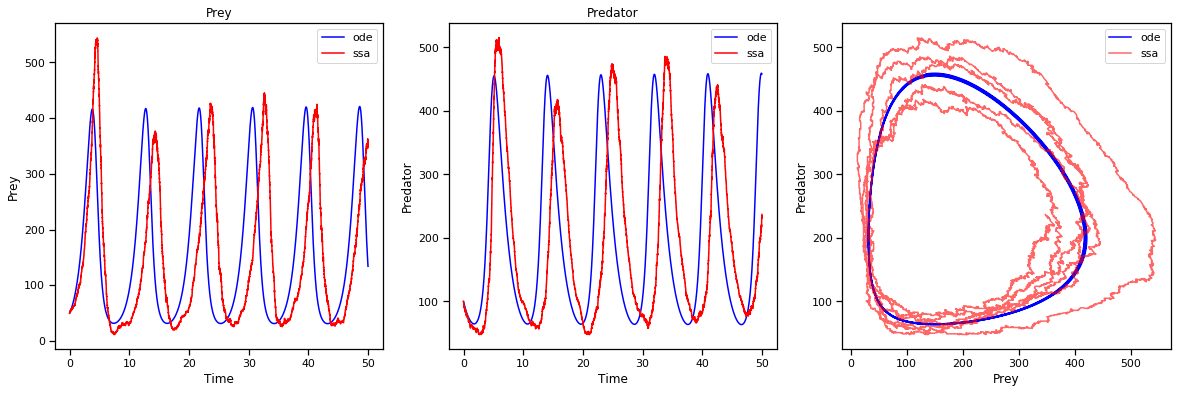

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(20,6))
ax = axes[0]
ax.plot(T, X, color="blue", label="ode")
ax.plot(t, x, color="red", label="ssa")
ax.set_xlabel("Time")
ax.set_ylabel("Prey")
ax.set_title("Prey")
ax.legend()

ax = axes[1]
ax.plot(T, Y, color="blue", label="ode")
ax.plot(t, y, color="red", label="ssa")
ax.set_xlabel("Time")
ax.set_ylabel("Predator")
ax.set_title("Predator")
ax.legend()

ax = axes[2]
ax.plot(X, Y, color="blue", label="ode")
ax.plot(x, y, color="red", label="ssa", alpha=0.6)
ax.set_xlabel("Prey")
ax.set_ylabel("Predator")
ax.legend()

plt.show()

## Ex 2

**Compute the extinction probability of the predators in the first 50 days (assuming `t` is in days) and plot it as a function of $h$ the hunting probability.**

The extinction probability is the probability that the predators populations size reaches zero.
To do that, you will have to run many simulations for the same parameters and check what is the fraction that finished with zero predators.

Think: How many replications should you use per parameter set?
Remember that the standard error of the mean generally decreases like the root of the number of observations ($\sqrt{n}$).

When choosing the number of $h$ values, think if you want to use `np.linspace` or `np.logspace`, or maybe draw random values (from which distribution?) and how many points you should use.

Note that this exercise will require running many simulations; if we estimate the probability from just 100 simulations, and plot against just 10 values of $h$, we still need to run 1000 simulations.

There are several ways to attack this, and they are not mutually exclusive:
1. optimize the simulation code
1. run in parallel on multiple cores on your own machine (see end of lecture 9).
1. use cloud computing on your own (see end of lecture 9).

At any case, make sure to save your simulation results to files so that you can reload them again and change the analysis or plot the figure again (but do not include these files in the assignment submission).

In [14]:
def extinction_probability(b, h, ϵ, d, x0=X[0], y0=Y[0], reps=1): ###
    # defining the function we wish to call
    f = gillespie_ssa
    # setting the parameters
    kwargs = dict(b=b,h=h,ϵ=ϵ, d=d)
    zero_count = 0
    with ProcessPoolExecutor() as executor:
          futures = [executor.submit(f, **kwargs) for _ in range(reps)]

    results = []
    for fut in as_completed(futures):
        if fut.exception():
            warnings.warn(str(fut.exception()))
        else:
            results.append(fut.result())
    
    results = np.array(results)
    zero_count = (results[:,-1, -1] == 0).mean()
    return zero_count

<span style="color:blue">I used AWS in order to minimize my computation time. I used 16 CPU's and the best case running time was under 20mins.</span>

In [15]:
%%time 
hs = np.logspace(-3, 0, 30) ###
ps = np.array([extinction_probability(b, h_, ϵ, d, reps=1000) for h_ in hs]) ###

CPU times: user 34.7 s, sys: 48.9 s, total: 1min 23s
Wall time: 18min 29s


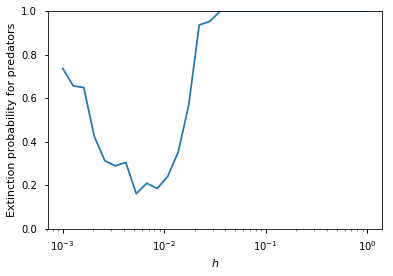

In [16]:
###
plt.plot(hs, ps)
plt.xlabel('$h$')
plt.ylabel('Extinction probability for predators')
plt.ylim(0, 1)
plt.xscale('log');

# Ex 3

Here's data from a real predator-prey system -- the hare and lynx system:

In [12]:
data = np.fromstring("""0 20 10 
2 55 15 
4 65 55 
6 95 60 
8 55 20 
10 5 15 
12 15 10 
14 50 60 
16 75 60 
18 20 10 
20 25 5 
22 50 25 
24 70 40 
26 30 25 
28 15 5 
""", sep=' ', dtype=int)
data = data.reshape(-1, 3)
data[:, 1] *= 1000
data[:, 2] *= 100
print(data)

[[    0 20000  1000]
 [    2 55000  1500]
 [    4 65000  5500]
 [    6 95000  6000]
 [    8 55000  2000]
 [   10  5000  1500]
 [   12 15000  1000]
 [   14 50000  6000]
 [   16 75000  6000]
 [   18 20000  1000]
 [   20 25000   500]
 [   22 50000  2500]
 [   24 70000  4000]
 [   26 30000  2500]
 [   28 15000   500]]


The first column is years, the second is hare population size, the third is lynx population size.

Let's plot the data.

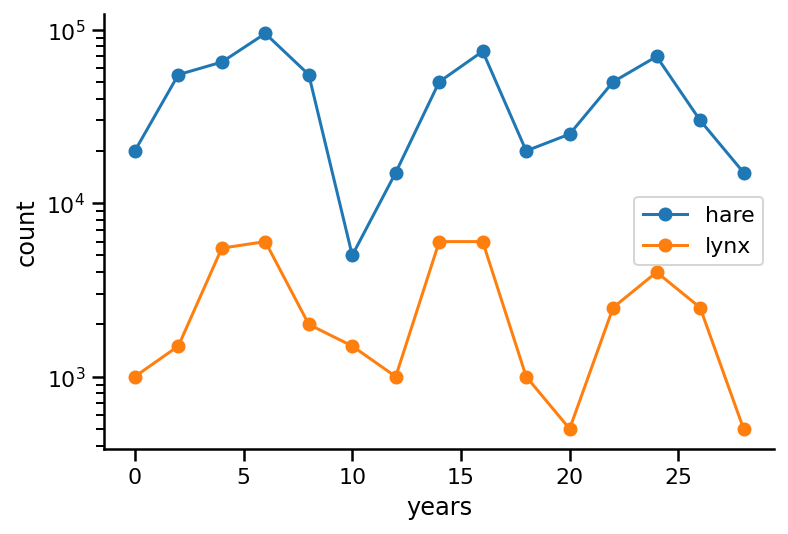

In [13]:
t, hare, lynx = data.T

plt.plot(t, hare, '-o', label='hare')
plt.plot(t, lynx, '-o', label='lynx')
plt.yscale('log')
plt.xlabel('years')
plt.ylabel('count')
plt.legend()

sns.despine()

We can see the cycles that we discussed in lecture 8.

**Now use ABC to fit a model to the data**, just as we did in lecture 10.

Do not use summary statistics, rather, calculate the MAE (mean absolute error) between the data and the simulations.
The `ABCSMC` constructor's third argument is a distance function that accepts the simulation dict as a first argument and the real dict as a second argument (the real dict is the observations dictionary you give to the `new` method later on). See [example](https://pyabc.readthedocs.io/en/latest/examples/parameter_inference.html).

**Tips**
- for `b` and `d` choose an `halfnorm(1)` prior distribution
- for `h` and `ϵ` choose `uniform(0, 1)` prior distribution
- if you get division by zero errors, the population has probably gone extinct, you should make sure you stop the simulation when the population is extinct
- running time may vary, but will take at least several minutes and even hours
- the printed values below are random

In [14]:
import pyabc
from corner import corner

In [15]:
priors = pyabc.Distribution( ###



)
priors.rvs() ###

<Parameter 'b': 2.0751597257125995, 'h': 0.8577349724295732, 'ε': 0.918692774515208, 'd': 1.2382140240930384>

In [16]:
def model(params): ###

    
    
model(priors.rvs()) ###

{'hare': array([2.e+04, 1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00]),
 'lynx': array([1000., 6739.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.])}

In [17]:
def distance(x, y): ###


observation = ### what should this be?
distance(model(priors.rvs()), observation) ###

45191.2

In [31]:
abc = pyabc.ABCSMC(
    model, 
    priors,
    distance,
    population_size= , # start with a small number, and if everything runs, use a larger value
#     sampler=pyabc.SingleCoreSampler() # only needed on Mac
)
db_path = "sqlite:///pyabc_hare_lynx.db"

In [ ]:
abc_id = abc.new(db_path, observation) ###

In [ ]:
%%time ###
history = abc.run(???) # choose arguments for run(...)

In [46]:
abc.load(db_path, 1) ### you can change the id value from 1
history = abc.history ###

**Print the point estimates of the model parameters**.

In [ ]:




print("b_hat = {:.3f}\nh_hat = {:.3f}\nε_hat = {:.3f}\nd_hat = {:.3f}".format(*params_hat))  ###

**Plot the approximated posterior distributions** of the model parameters.

**end of assignment**